In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import qmc
import numpy.random as random
import vegas

In [7]:
def standardd(mean, array):
    
    a = abs(array - mean)**2
    std = np.sqrt(np.mean(a, axis=0))

    return std

In [8]:
class particle:
     def __init__(self, alive, mu, x, weight):
        self.alive = alive
        self.mu = mu
        self.x = x
        self.weight = weight

In [745]:
def mc_iso(sigmaS, sigmaA, q, W, L, N, UQ, ux):
    bins = 50
    flux = np.zeros(bins)  
    
    if UQ:
        x = np.linspace(0, L, bins)
        sigmaA = sigmaA + ux * np.sin(np.pi / L * x) * np.random.randn()
    else:
        sigmaA = np.ones(bins) * sigmaA
        
    sigmaT = sigmaS + sigmaA

    for i in range(N):
        #create particle
        x = W * np.random.random()
        mu = 2 * np.random.random() - 1 #mu between -1 and 1
        p = particle(True, mu, x, q)

        while p.alive:
            #calculate distance to collision
            tally = int(p.x / L * bins)
            distance_to_collision = abs(-np.log(np.random.random())/sigmaT[tally])
            
            #calculate distance to surface
            if p.mu < 0:
                distance_to_boundary = abs(p.x/p.mu)
            elif p.mu > 0:
                distance_to_boundary = (L-p.x)/p.mu
            
            
            #tally if distance to collision is greater than distance to boundary
            if distance_to_collision > distance_to_boundary:
                while distance_to_collision > distance_to_boundary:
                    distance_to_collision = distance_to_collision - distance_to_boundary
                    p.mu = -p.mu
                    if p.mu < 0:
                        distance_to_boundary = abs(p.x/p.mu)
                    elif p.mu > 0:
                        distance_to_boundary = (L-p.x)/p.mu
                    
                    
                #print(p.x, p.mu, distance_to_boundary, distance_to_collision)
                if p.mu > 0:
                    #p.mu = -p.mu
                    p.x = distance_to_collision * p.mu
                    #flux[0] += p.weight
                    #p.alive = False
                elif p.mu < 0:
                    #flux[bins-1] += p.weight
                    #p.mu = p.mu * -1
                    p.x = L + distance_to_collision * p.mu
                    #p.alive = False
                    
                
                tally = int(p.x / L * bins)
                if np.random.random() < sigmaA[tally]/sigmaT[tally]: #absorbed
                    tally = int(p.x / L * bins)
                    flux[tally] += p.weight
                    p.alive = False
                else: #isotropic scatter
                    p.mu = 2 * np.random.random() - 1
                           
            else:
                p.x += distance_to_collision * p.mu

                tally = int(p.x / L * bins)
                if np.random.random() < sigmaA[tally]/sigmaT[tally]: #absorbed
                    tally = int(p.x / L * bins)
                    flux[tally] += p.weight
                    p.alive = False
                else: #isotropic scatter
                    p.mu = 2 * np.random.random() - 1

    #return weighted sum and tally
    return flux / N

### Scattering

In [726]:
sigmaS = 0
sigmaA = np.ones(50)
for i in range(25):
    sigmaA[i] = 2

q = 1
L = 3
W = 3

tallies_flat_rand2 = np.zeros((20,50))

for i in range(20):
    tallies_flat_rand2[i,:] = mc_iso(sigmaS, sigmaA, q, W, L, 1000000, True, .2)

In [727]:
np.std(tallies_flat_rand2)

0.0016840200723269303

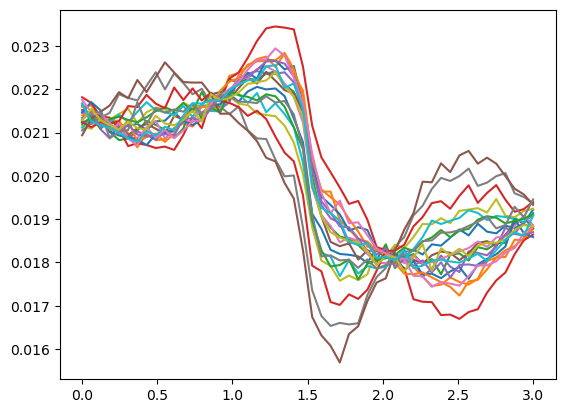

In [728]:
for i in range(20):
    plt.plot(np.linspace(0,L,50), tallies_flat_rand2[i,:])

In [753]:
sigmaS = 0
sigmaA = np.ones(50)
for i in range(25):
    sigmaA[i] = 2

q = 1
L = 2
W = 2

tallies_flat_normal2 = np.zeros((20,50))

for i in range(20):
    tallies_flat_normal2[i,:] = mc_iso(sigmaS, sigmaA, q, W, L, 100000, False, 1)

In [754]:
np.std(tallies_flat_normal2)

0.0018869306823516333

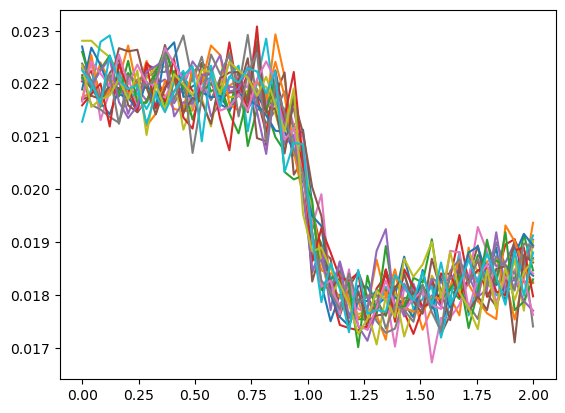

In [755]:
for i in range(20):
    plt.plot(np.linspace(0,L,50), tallies_flat_normal2[i,:])

### plot sin(x), sin(y)

Text(0, 0.5, 'y')

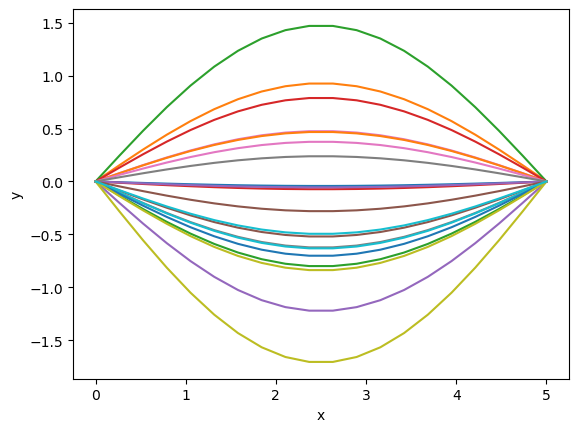

In [1370]:
x = np.linspace(0,5,20)
y = np.sin(x * np.pi/5)

for i in range(20):
    plt.plot(x,y*np.random.randn())
    
plt.xlabel('x')
plt.ylabel('y')

## B

In [9]:
def mc_iso_b(sigmaS, sigmaA, q, W, L, N, UQ, ux):
    surfaces = 20 + 1
    bins = 20
    dx = L / (bins)
    flux = np.zeros(bins)  
    
    if UQ:
        x = np.linspace(0, L, bins)
        sigmaA = sigmaA + ux * np.sin(np.pi / L * x) * np.random.randn()
    else:
        sigmaA = np.ones(bins) * sigmaA
        
    sigmaT = sigmaS + sigmaA

    for i in range(N):
        #create particle
        x = W * np.random.random()
        mu = 2 * np.random.random() - 1 #mu between -1 and 1
        p = particle(True, mu, x, q)

        while p.alive:
            tally = int(p.x / L * bins)
            distance_to_collision = -np.log(np.random.random())/sigmaT[tally]
            
            if p.mu < 0:
                distance_to_surface = abs((p.x - (tally * dx)) / p.mu)
            elif p.mu > 0:
                distance_to_surface = abs(((((tally+1) * dx) - p.x)) / p.mu)
                
            
                
            #calculate distance to surface
            while abs(distance_to_collision) > abs(distance_to_surface):
                #print(p.x, p.mu, distance_to_collision, distance_to_surface)
                #print("done")
                tally = int(p.x / L * bins) 
                
                if p.mu < 0:
                    
                    
                    
                    if tally == 0:
                        p.mu = -p.mu
                        distance_traveled = distance_to_surface
                        distance_to_collision += -distance_traveled
                        flux[tally] += abs(distance_traveled * p.mu)
                        p.x = tally * dx
                    else:
                        #distance_traveled = (distance_to_surface) * sigmaT[tally] / sigmaT[tally-1]
                        distance_traveled = distance_to_surface
                        distance_to_collision += -distance_traveled
                        flux[tally] += abs(distance_traveled * p.mu)
                        
                    p.x = (tally) * dx - .000000000000001    

                    distance_to_surface = abs(dx / p.mu)
                    
                elif p.mu > 0:
                       
                    if tally == (bins-1):
                        #p.mu = -p.mu
                        distance_traveled = (distance_to_surface)
                        distance_to_collision += -distance_traveled
                        flux[tally] += abs(distance_traveled * p.mu)
                        p.x = (tally+1) * dx
                    else:
                        #distance_traveled = (distance_to_surface) * sigmaT[tally] / sigmaT[tally+1]
                        distance_traveled = distance_to_surface
                        distance_to_collision += -distance_traveled
                        flux[tally] += abs(distance_traveled * p.mu)
                        p.x = (tally+1) * dx
                
                    if p.x == (bins) * dx:
                        p.mu = -p.mu
                        p.x +=  -.000000000000001
                
                distance_to_surface = abs(dx / p.mu)

                #print(p.x, p.mu, distance_to_collision, distance_to_surface)
                #print('end')
                #print(p.x, p.mu, distance_to_collision, distance_to_surface)
            
            #print("line")
            
            #print(p.x, p.mu, distance_to_collision, distance_to_surface)
            
            tally = int(p.x / L * bins)
            flux[tally] += distance_to_collision * p.mu
            
            #print(p.x)
            
            tally = int(p.x / L * bins)
            if np.random.random() < sigmaA[tally]/sigmaT[tally]: #absorbed
                #tally = int(p.x / L * bins)
                #flux[tally] += p.weight    
                p.alive = False
                
            else: #isotropic scatter
                p.mu = 2 * np.random.random() - 1

    #return weighted sum and tally
    return flux / N

## Scattering

In [1142]:
sigmaS = .5
sigmaA = np.ones(20)

for i in range(10):
    sigmaA[i] = 2
    
q = 1
L = 5
W = 5


tallies_scatter_normal1 = np.zeros((20,20))

for i in range(20):
    tallies_scatter_normal1[i,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 100000, False, .5)

Text(0, 0.5, 'Flux')

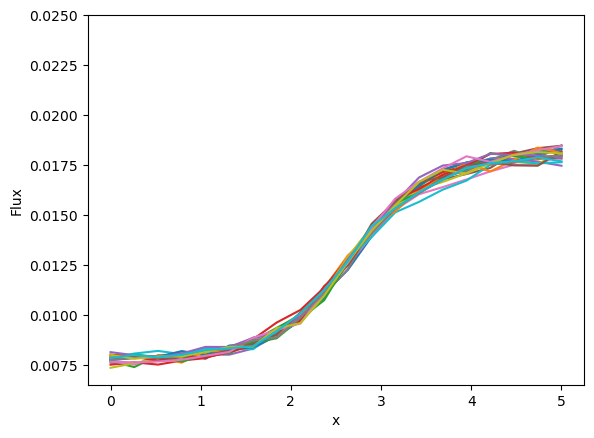

In [1266]:
for i in range(20):
    plt.plot(np.linspace(0,L,20), tallies_scatter_normal1[i,:])
plt.ylim((.0065, .025))
plt.xlabel('x')
plt.ylabel('Flux')

In [1214]:
np.std(tallies_scatter_normal1)
np.mean(tallies_scatter_normal1)

0.012543940584084402

In [1152]:
sigmaS = .5
sigmaA = np.ones(20)

for i in range(10):
    sigmaA[i] = 2
    
q = 1
L = 5
W = 5


tallies_scatter_rand1 = np.zeros((20,20))

for i in range(20):
    tallies_scatter_rand1[i,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 100000, True, .25)

Text(0, 0.5, 'Flux')

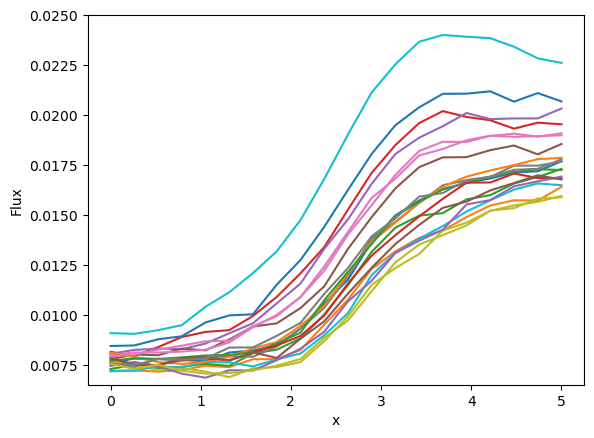

In [1265]:
for i in range(20):
    plt.plot(np.linspace(0,L,20), tallies_scatter_rand1[i,:])
plt.ylim((.0065, .025))
plt.xlabel('x')
plt.ylabel('Flux')

In [1215]:
std_rand1 = np.std(tallies_scatter_rand1)
mean_rand1 = np.mean(tallies_scatter_rand1)

## Two material absorber

In [9]:
sigmaS = 0
sigmaA = np.ones(20)
for i in range(10):
    sigmaA[i] = 2

q = 1
L = 5
W = 5

tallies_flat_normal9 = np.zeros((20,20))

for i in range(20):
    tallies_flat_normal9[i,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 100000, False, 1)

Text(0, 0.5, 'Flux')

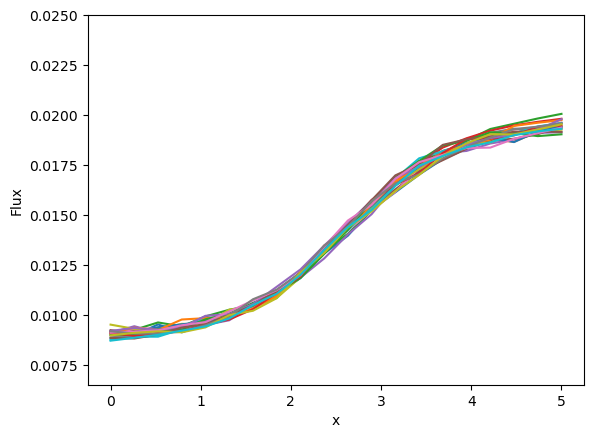

In [10]:
for i in range(20):
    plt.plot(np.linspace(0,L,20), tallies_flat_normal9[i,:])
plt.ylim((.0065, .025))
plt.xlabel('x')
plt.ylabel('Flux')

In [1321]:
np.mean(tallies_flat_normal9, axis=0)

array([0.00907231, 0.00910505, 0.00921435, 0.00934568, 0.00958692,
       0.01000616, 0.01047123, 0.01111745, 0.01199824, 0.01318651,
       0.01428689, 0.01537635, 0.01646139, 0.01733476, 0.01808082,
       0.01858159, 0.01893637, 0.01915243, 0.0192329 , 0.01929167])

In [1071]:
np.std(tallies_flat_normal9)

0.003984178269144284

In [1155]:
sigmaS = 0
sigmaA = np.ones(20)

for i in range(10):
    sigmaA[i] = 2
    
q = 1
L = 5
W = 5


tallies_two_rand1 = np.zeros((20,20))

for i in range(20):
    tallies_two_rand1[i,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 100000, True, .25)

(0.0065, 0.025)

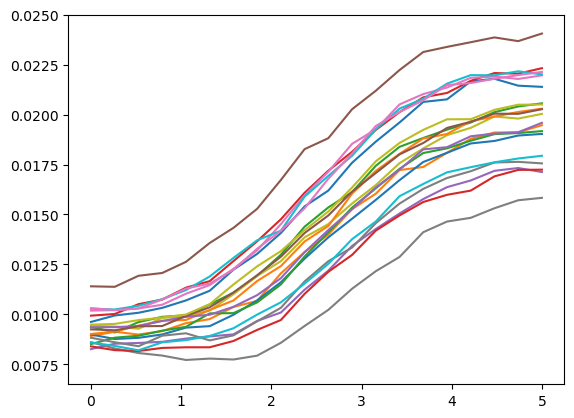

In [1169]:
for i in range(20):
    plt.plot(np.linspace(0,L,20), tallies_two_rand1[i,:])
plt.ylim((.0065, .025))

In [1158]:
np.std(tallies_two_rand1)

0.00445235433581572

### Std of two material absorber

In [10]:
sigmaS = 0
sigmaA = np.ones(20)
for i in range(10):
    sigmaA[i] = 2

q = 1
L = 5
W = 5

tallies_std_normal1 = mc_iso_b(sigmaS, sigmaA, q, W, L, 100000000, False, .5)
std_two_absorb = np.std(tallies_std_normal1)

In [11]:
print(std_two_absorb)

0.004005479445181519


In [12]:
sigmaS = 0
sigmaA = np.ones(20)
for i in range(10):
    sigmaA[i] = 2

q = 1
L = 5
W = 5


dif3 = [.01, .05, .1, .3, .5]
std3 = np.zeros(5)
t=0

for i in dif3:
    print(i)
    tallies_two_absorb = np.zeros((20,20))
    for j in range(20):
        tallies_two_absorb[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, i)
    std3[t] = np.std(tallies_two_absorb)
    t += 1

0.01
0.05
0.1


KeyboardInterrupt: 

In [1212]:
print(dif3, std3)

[0.01, 0.05, 0.1, 0.3, 0.5] [0.00401214 0.00404291 0.00405696 0.00524825 0.1312163 ]


In [1213]:
print(abs((std3 / std_two_absorb)-1) * 100, "percent increases from normal")

[2.19421775e-01 9.87894943e-01 1.33883554e+00 3.10960660e+01
 3.17765416e+03] percent increases from normal


### Std of two material absorber with scattering

In [1203]:
sigmaS = .5
sigmaA = np.ones(20)
for i in range(10):
    sigmaA[i] = 2

q = 1
L = 5
W = 5

tallies_std_normal1 = mc_iso_b(sigmaS, sigmaA, q, W, L, 100000000, False, .5)
std_two_normal = np.std(tallies_std_normal1)

In [1204]:
print(std_two_normal)

0.004140149578763122


In [1195]:
sigmaS = .5
sigmaA = np.ones(20)
for i in range(10):
    sigmaA[i] = 2

q = 1
L = 5
W = 5


dif2 = [.01, .05, .1, .3, .5]
std2 = np.zeros(5)
t=0

for i in dif2:
    print(i)
    tallies_two_scatter = np.zeros((20,20))
    for j in range(20):
        tallies_two_scatter[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, i)
    std2[t] = np.std(tallies_two_scatter)
    t += 1

0.01
0.05
0.1
0.3
0.5


In [1196]:
print(dif2, std2)

[0.01, 0.05, 0.1, 0.3, 0.5] [0.00414413 0.00417693 0.00438675 0.00498577 0.00598949]


In [1206]:
print(abs((std2 / std_two_normal)-1) * 100, "percent increases from normal")

[ 3.35706458  3.36396132  3.09321719 20.9231751  19.42098215] percent increases from normal


## Flat

In [13]:
sigmaS = 0
sigmaA = np.ones(20)*3
q = 1
L = 5
W = 5

tallies_flat_normal5 = np.zeros((20,20))

for i in range(20):
    tallies_flat_normal5[i,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, False, 1)

In [14]:
np.std(tallies_flat_normal5)

3.8002288248817874e-05

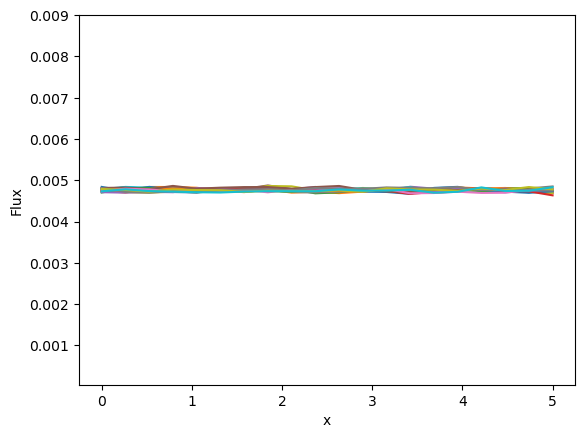

In [19]:
for i in range(20):
    plt.plot(np.linspace(0,L,20), tallies_flat_normal5[i,:])
plt.ylim((0.00005,.009))
plt.xlabel('x')
plt.ylabel('Flux')
plt.show()

In [1054]:
sigmaS = 0
sigmaA = np.ones(20)*2
q = 1
L = 5
W = 5

tallies_flat5 = np.zeros((20,20))

for i in range(20):
    tallies_flat5[i,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, .5)

In [1055]:
np.std(tallies_flat)

0.0003453054705619359

Text(0, 0.5, 'Flux')

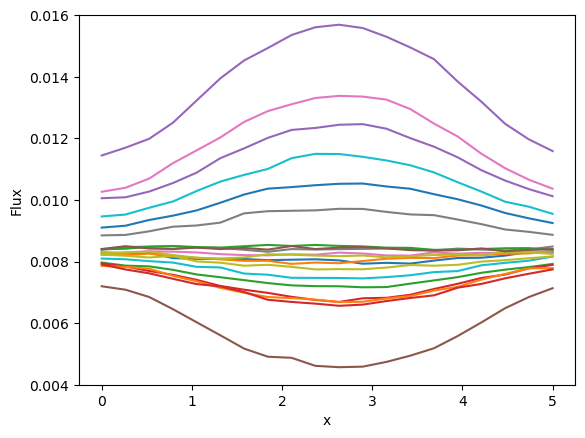

In [1268]:
for i in range(20):
    plt.plot(np.linspace(0,L,20),tallies_flat5[i,:])
plt.ylim((0.004,.016))
plt.xlabel('x')
plt.ylabel('Flux')

## Std of flat absorber

0.01
0.1
0.2
0.5
1


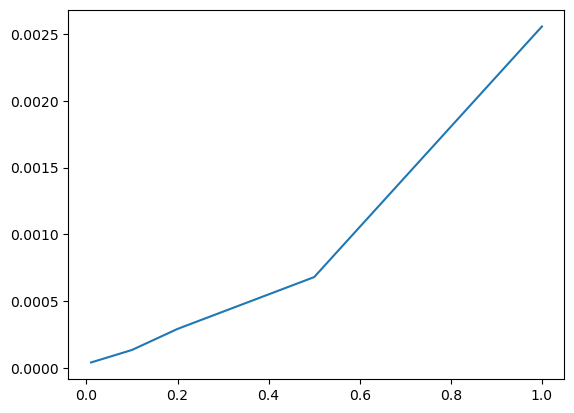

In [1111]:
sigmaS = 0
sigmaA = np.ones(20) * 3
#for i in range(10):
#    sigmaA[i] = 3

q = 1
L = 5
W = 5


dif = [.01, .1, .2, .5, 1]
std = np.zeros(5)
t=0

for i in dif:
    print(i)
    tallies_flat_rand4 = np.zeros((20,20))
    for j in range(20):
        tallies_flat_rand4[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, i)
    std[t] = np.std(tallies_flat_rand4)
    t += 1

In [1112]:
print(dif, std)

[0.01, 0.1, 0.2, 0.5, 1] [3.99515618e-05 1.33828862e-04 2.91479670e-04 6.79724023e-04
 2.55730751e-03]


In [1129]:
print(((std / normal_std)-1) * 100, "percent increases from normal")

[   7.14483032  258.91139265  681.71011131 1722.93036335 6758.3621344 ] percent increases from normal


## Graphs

In [12]:
sigmaS = 0
sigmaA = np.ones(20) * 3
#for i in range(10):
#    sigmaA[i] = 3

q = 1
L = 5
W = 5

dif = [.01, .1, .2, .5, 1]
std = np.zeros(5)
t=0

tallies_flat_rand_graph1 = np.zeros((20,20))
for j in range(20):
    tallies_flat_rand_graph1[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, .01)

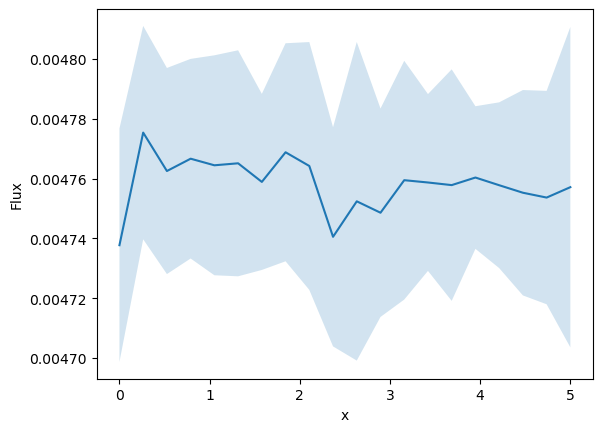

In [13]:
mean1 = np.mean(tallies_flat_rand_graph1, axis=0)
sd1 = np.std(tallies_flat_rand_graph1, axis=0)

plt.plot(np.linspace(0,L,20), mean1, label="Flux")
plt.fill_between(np.linspace(0,L,20), mean1 - sd1, mean1 + sd1, alpha=.2)
plt.xlabel("x")
plt.ylabel("Flux")
plt.show()

In [14]:
sigmaS = 0
sigmaA = np.ones(20) * 3
#for i in range(10):
#    sigmaA[i] = 3

q = 1
L = 5
W = 5

dif = [.01, .1, .2, .5, 1]
std = np.zeros(5)
t=0

tallies_flat_rand_graph3 = np.zeros((20,20))
for j in range(20):
    tallies_flat_rand_graph3[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, .1)

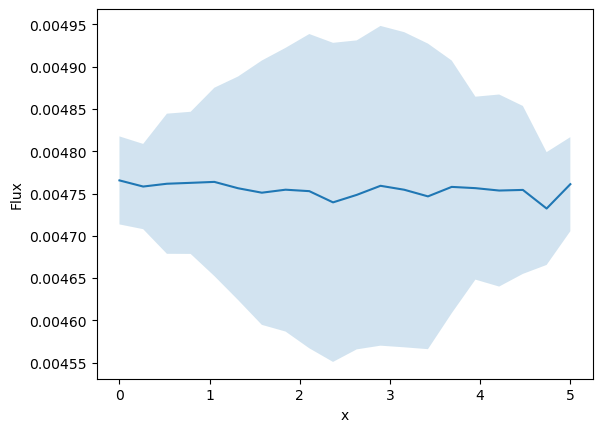

In [15]:
mean3 = np.mean(tallies_flat_rand_graph3, axis=0)
sd3 = np.std(tallies_flat_rand_graph3, axis=0)

plt.plot(np.linspace(0,L,20), mean3, label="Flux")
plt.fill_between(np.linspace(0,L,20), mean3 - sd3, mean3 + sd3, alpha=.2)
plt.xlabel("x")
plt.ylabel("Flux")
plt.show()

In [16]:
sigmaS = 0
sigmaA = np.ones(20) * 3
#for i in range(10):
#    sigmaA[i] = 3

q = 1
L = 5
W = 5

dif = [.01, .1, .2, .5, 1]
std = np.zeros(5)
t=0

tallies_flat_rand_graph4 = np.zeros((20,20))
for j in range(20):
    tallies_flat_rand_graph4[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, .2)

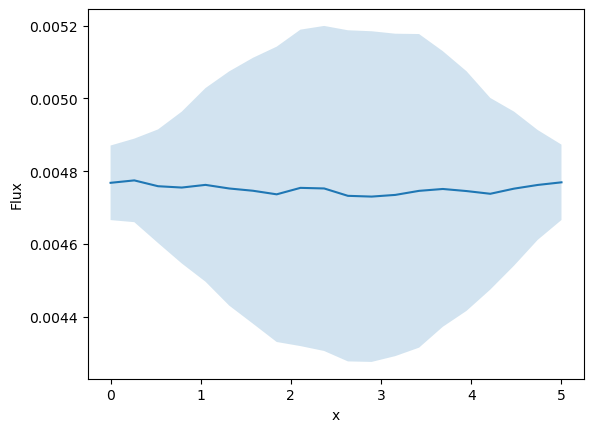

In [17]:
mean4 = np.mean(tallies_flat_rand_graph4, axis=0)
sd4 = np.std(tallies_flat_rand_graph4, axis=0)

plt.plot(np.linspace(0,L,20), mean4, label="Flux")
plt.fill_between(np.linspace(0,L,20), mean4 - sd4, mean4 + sd4, alpha=.2)
plt.xlabel("x")
plt.ylabel("Flux")
plt.show()

In [18]:
sigmaS = 0
sigmaA = np.ones(20) * 3
#for i in range(10):
#    sigmaA[i] = 3

q = 1
L = 5
W = 5

dif = [.01, .1, .2, .5, 1]
std = np.zeros(5)
t=0

tallies_flat_rand_graph5 = np.zeros((20,20))
for j in range(20):
    tallies_flat_rand_graph5[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, .5)

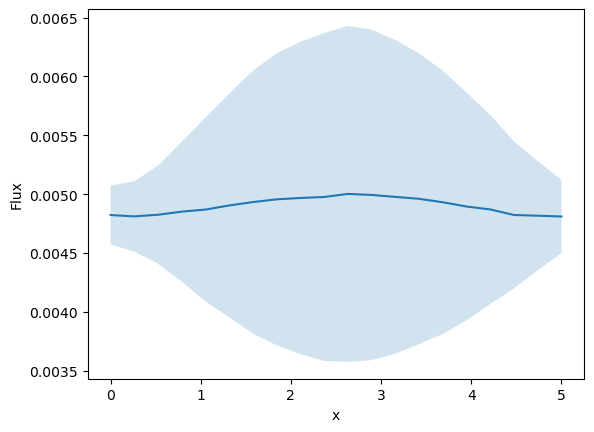

In [19]:
mean5 = np.mean(tallies_flat_rand_graph5, axis=0)
sd5 = np.std(tallies_flat_rand_graph5, axis=0)

plt.plot(np.linspace(0,L,20), mean5, label="Flux")
plt.fill_between(np.linspace(0,L,20), mean5 - sd5, mean5 + sd5, alpha=.2)
plt.xlabel("x")
plt.ylabel("Flux")
plt.show()

In [20]:
sigmaS = 0
sigmaA = np.ones(20) * 3
#for i in range(10):
#    sigmaA[i] = 3

q = 1
L = 5
W = 5

dif = [.01, .1, .2, .5, 1]
std = np.zeros(5)
t=0

tallies_flat_rand_graph6 = np.zeros((20,20))
for j in range(20):
    tallies_flat_rand_graph6[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, 1)

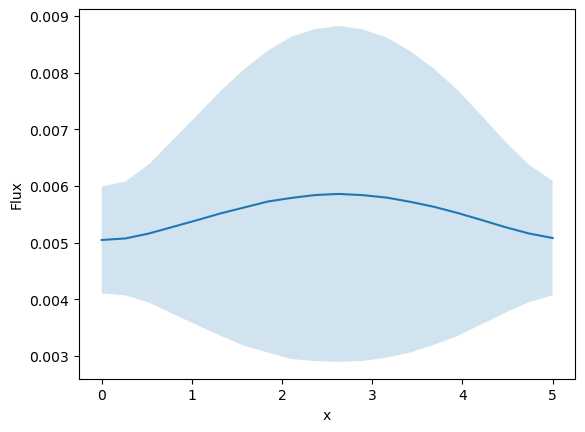

In [21]:
mean6 = np.mean(tallies_flat_rand_graph6, axis=0)
sd6 = np.std(tallies_flat_rand_graph6, axis=0)

plt.plot(np.linspace(0,L,20), mean6, label="Flux")
plt.fill_between(np.linspace(0,L,20), mean6 - sd6, mean6 + sd6, alpha=.2)
plt.xlabel("x")
plt.ylabel("Flux")
plt.show()

In [22]:
sigmaS = 0
sigmaA = np.ones(20) * 3
#for i in range(10):
#    sigmaA[i] = 3

q = 1
L = 5
W = 5

dif = [.01, .1, .2, .5, 1]
std = np.zeros(5)
t=0

tallies_flat_rand_graph2 = np.zeros((20,20))
for j in range(20):
    tallies_flat_rand_graph2[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, False, .01)

In [23]:
mean2 = np.mean(tallies_flat_rand_graph2, axis=0)
sd2 = np.std(tallies_flat_rand_graph2, axis=0)

In [24]:
sd6 = standardd(mean2, tallies_flat_rand_graph6)
sd5 = standardd(mean2, tallies_flat_rand_graph5)
sd4 = standardd(mean2, tallies_flat_rand_graph4)
sd3 = standardd(mean2, tallies_flat_rand_graph3)
sd1 = standardd(mean2, tallies_flat_rand_graph1)

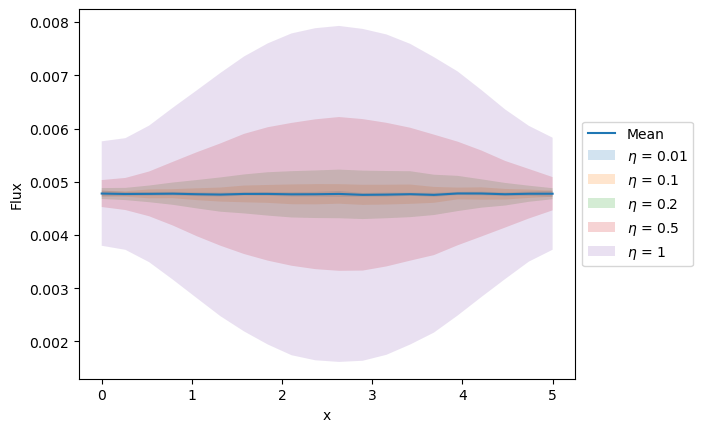

In [29]:
plt.plot(np.linspace(0,L,20), mean2, "-", label="Mean")
plt.fill_between(np.linspace(0,L,20), mean2 - sd1, mean2 + sd1, alpha=.2, label='$\eta$ = 0.01')
plt.fill_between(np.linspace(0,L,20), mean2 - sd3, mean2 + sd3, alpha=.2, label='$\eta$ = 0.1')
plt.fill_between(np.linspace(0,L,20), mean2 - sd4, mean2 + sd4, alpha=.2, label='$\eta$ = 0.2')
plt.fill_between(np.linspace(0,L,20), mean2 - sd5, mean2 + sd5, alpha=.2, label='$\eta$ = 0.5')
plt.fill_between(np.linspace(0,L,20), mean2 - sd6, mean2 + sd6, alpha=.2, label='$\eta$ = 1')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("x")
plt.ylabel("Flux")
plt.show()

In [1339]:
print(np.mean(sd6))
print(np.mean(sd5))
print(np.mean(sd4))
print(np.mean(sd3))
print(np.mean(sd1))
print(np.mean(sd2))

0.0027741846394242794
0.000576648254360107
0.0002895059730206188
0.0001588300799773719
4.3975685690164186e-05
3.6161650919736875e-05


## Two Absorber graphs

In [26]:
sigmaS = 0
sigmaA = np.ones(20)
for i in range(10):
    sigmaA[i] = 2

q = 1
L = 5
W = 5
tallies_std_normal10 = np.zeros((20,20))

for j in range(20):
    tallies_std_normal10[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, False, .5)

In [27]:
mean_1 = np.mean(tallies_std_normal10, axis=0)
sd_1 = standardd(mean_1, tallies_std_normal10)

In [30]:
sigmaS = 0
sigmaA = np.ones(20)
for i in range(10):
    sigmaA[i] = 2

q = 1
L = 5
W = 5


dif3 = [.01, .05, .1, .3, .5]
std_two_absorb = np.zeros((5,20))
t=0

for i in dif3:
    print(i)
    tallies_two_absorb = np.zeros((20,20))
    for j in range(20):
        tallies_two_absorb[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, i)
    std_two_absorb[t,:] = standardd(mean_1, tallies_two_absorb)
    t +=1

0.01
0.05
0.1
0.3
0.5


KeyboardInterrupt: 

In [ ]:
plt.plot(np.linspace(0,L,20), mean_1, "-", label="Mean")
plt.fill_between(np.linspace(0,L,20), mean_1 - std_two_absorb[0,:], mean_1 + std_two_absorb[0,:], alpha=.2, label='$\eta$ = 0.01')
plt.fill_between(np.linspace(0,L,20), mean_1 - std_two_absorb[1,:], mean_1 + std_two_absorb[1,:], alpha=.2, label='$\eta$ = 0.05')
plt.fill_between(np.linspace(0,L,20), mean_1 - std_two_absorb[2,:], mean_1 + std_two_absorb[2,:], alpha=.2, label='$\eta$ = 0.1')
plt.fill_between(np.linspace(0,L,20), mean_1 - std_two_absorb[3,:], mean_1 + std_two_absorb[3,:], alpha=.2, label='$\eta$ = 0.3')
plt.fill_between(np.linspace(0,L,20), mean_1 - std_two_absorb[4,:], mean_1 + std_two_absorb[4,:], alpha=.2, label='$\eta$ = 0.5')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("x")
plt.ylabel("Flux")
plt.show()

In [1346]:
print(np.mean(sd_1))
print(np.mean(std_two_absorb[0,:]))
print(np.mean(std_two_absorb[1,:]))
print(np.mean(std_two_absorb[2,:]))
print(np.mean(std_two_absorb[3,:]))
print(np.mean(std_two_absorb[4,:]))

5.9709880201844225e-05
0.00012024890596952853
0.00039449195830534525
0.0009633644233603489
0.0019692987392436303
0.0051376794782432835


## Two Absorber scattering graphs

In [ ]:
sigmaS = .5
sigmaA = np.ones(20)

for i in range(10):
    sigmaA[i] = 2
    
q = 1
L = 5
W = 5

tallies_std_normal12 = np.zeros((20,20))

for j in range(20):
    tallies_std_normal12[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, False, .5)

In [ ]:
meana_1 = np.mean(tallies_std_normal12, axis=0)
sda_1 = standardd(meana_1, tallies_std_normal12)

In [ ]:
sigmaS = .5
sigmaA = np.ones(20)

for i in range(10):
    sigmaA[i] = 2
    
q = 1
L = 5
W = 5


dif3 = [.01, .05, .1, .2, .25]
std_two_absorba = np.zeros((5,20))
t=0

for i in dif3:
    print(i)
    tallies_two_absorba = np.zeros((20,20))
    for j in range(20):
        tallies_two_absorba[j,:] = mc_iso_b(sigmaS, sigmaA, q, W, L, 1000000, True, i)
    std_two_absorba[t,:] = standardd(meana_1, tallies_two_absorba)
    t +=1

In [ ]:
plt.plot(np.linspace(0,L,20), meana_1, "-", label="Mean")
plt.fill_between(np.linspace(0,L,20), meana_1 - std_two_absorba[0,:], meana_1 + std_two_absorba[0,:], alpha=.2, label='$\eta$ = 0.01')
plt.fill_between(np.linspace(0,L,20), meana_1 - std_two_absorba[1,:], meana_1 + std_two_absorba[1,:], alpha=.2, label='$\eta$ = 0.05')
plt.fill_between(np.linspace(0,L,20), meana_1 - std_two_absorba[2,:], meana_1 + std_two_absorba[2,:], alpha=.2, label='$\eta$ = 0.1')
plt.fill_between(np.linspace(0,L,20), meana_1 - std_two_absorba[3,:], meana_1 + std_two_absorba[3,:], alpha=.2, label='$\eta$ = 0.2')
plt.fill_between(np.linspace(0,L,20), meana_1 - std_two_absorba[4,:], meana_1 + std_two_absorba[4,:], alpha=.2, label='$\eta$ = 0.25')


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("x")
plt.ylabel("Flux")
plt.show()

In [1365]:
print(np.mean(sda_1))
print(np.mean(std_two_absorba[0,:]))
print(np.mean(std_two_absorba[1,:]))
print(np.mean(std_two_absorba[2,:]))
print(np.mean(std_two_absorba[3,:]))
print(np.mean(std_two_absorba[4,:]))

5.714918062955259e-05
9.304830284391648e-05
0.0004610361565702367
0.0006797989510735608
0.0015343717397643473
0.002651552929145067
